# Multilayer Perceptron

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

In [2]:
# Settings
BATCH_SIZE_TRAIN = 60000
BATCH_SIZE_TEST = 10000
RANDOM_SEED = 123
MINIBATCH_SIZE = 50
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


# Prepare data
train_dataset = datasets.MNIST(root='data',
                              train=True,
                              transform=transforms.ToTensor(),
                              download=True)

test_dataset = datasets.MNIST(root='data',
                             train=False,
                             transform=transforms.ToTensor(),
                             download=True)

train_loader = DataLoader(dataset=train_dataset,
                         batch_size=BATCH_SIZE_TRAIN,
                         shuffle=False)

test_loader = DataLoader(dataset=test_dataset,
                        batch_size=BATCH_SIZE_TEST,
                        shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



C:\Users\HP\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:189.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
# examine training set
for image, label in train_loader:
    print(f'Image Batch Size: {image.shape}')
    print(f'Label Batch Size: {label.shape}')
    break

Image Batch Size: torch.Size([60000, 1, 28, 28])
Label Batch Size: torch.Size([60000])


True Label: 5


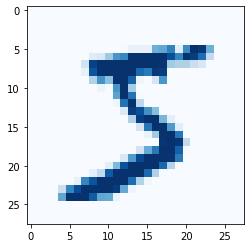

True Label: 0


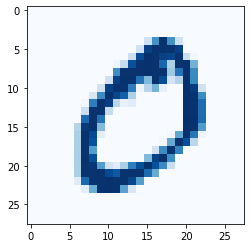

True Label: 4


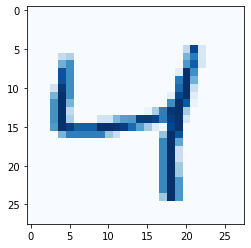

In [4]:
# examine training set
for idx, img in enumerate(image[0:3]):
    plt.imshow(img.view(28, 28), cmap='Blues')
    print(f'True Label: {label[idx]}')
    plt.show()

## Model Implementation

In [5]:
cost, minibatch_cost = [], []
start_time = time.time()

class MLP(torch.nn.Module):
    
    def __init__(self, num_features, num_hidden, num_classes):
        super(MLP, self).__init__()
        
        self.num_features = num_features
        self.num_hidden_1 = num_hidden
        self.num_classes = num_classes 
        
        # 1st layer
        self.linear_1 = torch.nn.Linear(num_features, num_hidden, DEVICE )
        self.linear_1.weight.detach().normal_(0, 0.1)
        self.linear_1.bias.detach().zero_()
        
        # 2nd layer
        self.linear_out = torch.nn.Linear(num_hidden, num_classes, DEVICE )
        self.linear_out.weight.detach().normal_(0, 0.1)
        self.linear_out.bias.detach().zero_()
        
        
    def forward(self, x):
        out = self.linear_1(x)
        out = torch.sigmoid(out)
        logits = self.linear_out(out)
        probas = torch.softmax(logits, dim=1)
        return logits, probas
    
    def compute_accuracy(self, y__pred_probas, y):
        y_pred = torch.argmax(y__pred_probas, dim=1)
        accuracy = torch.sum(y_pred == y) / y.shape[0]
        return accuracy
    
    ### Model training ###
    def train(self, x, y, num_epochs, minibatch_size=MINIBATCH_SIZE, seed=RANDOM_SEED):
        
        optimizer = torch.optim.SGD(self.parameters(), lr=0.1)
        shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)
        minibatches = torch.split(shuffle_idx, minibatch_size)
        torch.manual_seed(seed)
        
        for e in range(num_epochs):
            for minibatch_idx in minibatches:
                
                # forward probagation
                logits, probas = self.forward(x[minibatch_idx])
                
                # compute loss
                loss = F.cross_entropy(logits, y[minibatch_idx])
                
                # reset gradients from previous interaction
                optimizer.zero_grad()
                
                # comp. gradients
                loss.backward()
                
                # model updates
                optimizer.step()
                
                minibatch_cost.append(loss)
            
            ### Logging ###
            with torch.no_grad():
                logits, probas = self.forward(x)
                curr_loss = F.cross_entropy(logits, y)
                acc = self.compute_accuracy(probas, y)
                print('Epoch: %03d' %(e+1), end='')
                print(' | ACC Train: %.3f' %acc, end='')
                print(' | Loss: %.3f' %curr_loss, end='')
                print(' | Time elapsed: %.2f min' % ((time.time() - start_time) / 60))
                cost.append(curr_loss)
                
        print('\n - Total training time: %.2f min' %((time.time() - start_time) / 60))
                
    def predict(self, x):
        logits, probas = self.forward(x)
        y_pred = torch.argmax(probas, dim=1)
        return y_pred

In [6]:
X_train = image.view(-1, 28*28)
y_train = label

In [ ]:
# model initialization
model = MLP(num_features=X_train.size(1), num_hidden=100,  num_classes=10)
model.to(DEVICE )
model.train(X_train, y_train, num_epochs=50)

Epoch: 001 | ACC Train: 0.896 | Loss: 0.378 | Time elapsed: 0.04 min
Epoch: 002 | ACC Train: 0.913 | Loss: 0.306 | Time elapsed: 0.09 min
Epoch: 003 | ACC Train: 0.922 | Loss: 0.272 | Time elapsed: 0.13 min
Epoch: 004 | ACC Train: 0.929 | Loss: 0.247 | Time elapsed: 0.18 min
Epoch: 005 | ACC Train: 0.935 | Loss: 0.227 | Time elapsed: 0.22 min
Epoch: 006 | ACC Train: 0.940 | Loss: 0.210 | Time elapsed: 0.26 min
Epoch: 007 | ACC Train: 0.945 | Loss: 0.195 | Time elapsed: 0.31 min
Epoch: 008 | ACC Train: 0.948 | Loss: 0.182 | Time elapsed: 0.35 min
Epoch: 009 | ACC Train: 0.952 | Loss: 0.170 | Time elapsed: 0.39 min
Epoch: 010 | ACC Train: 0.955 | Loss: 0.160 | Time elapsed: 0.43 min
Epoch: 011 | ACC Train: 0.957 | Loss: 0.151 | Time elapsed: 0.48 min
Epoch: 012 | ACC Train: 0.959 | Loss: 0.143 | Time elapsed: 0.52 min
Epoch: 013 | ACC Train: 0.961 | Loss: 0.136 | Time elapsed: 0.57 min
Epoch: 014 | ACC Train: 0.963 | Loss: 0.129 | Time elapsed: 0.61 min
Epoch: 015 | ACC Train: 0.965 | Lo

In [ ]:
# Plotting the losses

plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.xlabel('Minibatch')
plt.ylabel('Cross Entropy')
plt.show()

plt.plot(range(len(cost)), cost)
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.show()

In [ ]:
for image_test, label_test in test_loader:
    print(f'Image Batch Size: {image_test.shape}')
    print(f'Label Batch Size: {label_test.shape}')
    break

In [ ]:
X_test = image_test.view(-1, 28*28)
y_test = label_test

In [ ]:
y_pred = model.predict(X_test)
print(f'Test ACC: {torch.sum(y_test == y_pred) / len(y_test)}')